# San Francisco Public Library patron dataset 

In [1]:
# this will only work if you first 'conda install geopandas' through Anaconda prompt. pip install works too. Require to run Anaconda prompt as administrator (that's right click at Anaconda prompt )
import geopandas as gpd
import descartes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

## Dataset

In [17]:
df=pd.read_csv("data/Library_Usage.csv")



In [4]:
df.head()

,Patron Type Code,Patron Type Definition,Total Checkouts,Total Renewals,Age Range,Home Library Code,Home Library Definition,Circulation Active Month,Circulation Active Year,Notice Preference Code,Notice Preference Definition,Provided Email Address,Year Patron Registered,Outside of County,Supervisor District
0,0,ADULT,1092,761,60 to 64 years,M6,Mission,July,2016,p,phone,False,2003,False,9.0
1,0,ADULT,0,0,20 to 24 years,P1,Park,None,None,z,email,True,2014,False,5.0
2,0,ADULT,31,22,25 to 34 years,S7,Sunset,April,2016,z,email,True,2010,False,4.0
3,0,ADULT,0,0,45 to 54 years,P1,Park,None,None,a,print,False,2016,True,NaN
4,0,ADULT,0,0,25 to 34 years,X,Main Library,None,None,z,email,True,2015,False,3.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423448 entries, 0 to 423447
Data columns (total 15 columns):
Patron Type Code                423448 non-null int64
Patron Type Definition          423448 non-null object
Total Checkouts                 423448 non-null int64
Total Renewals                  423448 non-null int64
Age Range                       423233 non-null object
Home Library Code               423408 non-null object
Home Library Definition         423448 non-null object
Circulation Active Month        423448 non-null object
Circulation Active Year         423448 non-null object
Notice Preference Code          423448 non-null object
Notice Preference Definition    423448 non-null object
Provided Email Address          423448 non-null bool
Year Patron Registered          423448 non-null int64
Outside of County               423448 non-null bool
Supervisor District             313138 non-null float64
dtypes: bool(2), float64(1), int64(4), object(8)
memory usage: 42.8+ MB

In [6]:
df.describe()
# only five numerical values. Patron Type Code, Supervisor District are technically factorial. Year Patron is interval, but can be used to calculate how many years a patron has a library card.

,Patron Type Code,Total Checkouts,Total Renewals,Year Patron Registered,Supervisor District
count,423448.000000,423448.000000,423448.000000,423448.000000,313138.000000
mean,1.036765,161.982097,59.657327,2010.348917,6.288240
std,4.188198,453.703678,225.009917,4.357374,3.123634
min,0.000000,0.000000,0.000000,2003.000000,1.000000
25%,0.000000,2.000000,0.000000,2007.000000,4.000000
50%,0.000000,19.000000,2.000000,2012.000000,6.000000
75%,1.000000,113.000000,27.000000,2014.000000,9.000000
max,104.000000,35907.000000,8965.000000,2016.000000,11.000000


### Check for missing values

In [3]:
df.isnull().sum().sort_values(ascending=False)


Supervisor District             110310
Age Range                          215
Home Library Code                   40
Outside of County                    0
Year Patron Registered               0
Provided Email Address               0
Notice Preference Definition         0
Notice Preference Code               0
Circulation Active Year              0
Circulation Active Month             0
Home Library Definition              0
Total Renewals                       0
Total Checkouts                      0
Patron Type Definition               0
Patron Type Code                     0
dtype: int64

Clearly, three variables - Supervisor District, Age Range, and Home Library Code - have missing values. Supervisor District is missing in approx. 25% of the dataset, so these records definitely could not be imputated. It is worth looking into why such the number is so big. 
Age Range, Home Library County is small enough, so it can be considered to be imputated. We will do it if we are using these for prediction

 "Supervisor District" is an automatically populated fields and will be left blank for users who are outside of country. That will explain high volume of null values in this particular field.  
From literature review, I found out that San Francisco Public Library (SFPL) considers equity and social justice as their service priority. They welcome patrons without fixed address - individuals who are homeless - to use their facilities.If the patron record without supervisor district indeed signifies that these are records from vulnerable population, it may be interesting to to run a Z-test to examine some of numerical variables, and/or chi-test to examine categorical variables.  
As a library professional, I really admire how SFPL deems serving the vulnerable population as part of their mandate. It also reminds me that, while it is important for libraries to show its values by using numbers and statistics - such as usage stats like total checkouts - part of its true value in the society is in providing services to those who are in need. The weakness of this particular dataset is that it only reflects the usage of those patrons who borrow materials form the library.  

# Initial Cleanup
That include removable variables with less values, such as 'Circulation Active Month'

We are also going to combine Total Checkouts and Total Renewals to create total_cko, as these are both circulation activities. And then, we are going to calculate the year_registered and average cko, since it is important to take number of years a patron has an account before evaluating the usage. 

In sum, three new variables will be created here, and one will be dropped

To be created:
- total_cko
- avg_cko
- years_registered

To be dropped
- Circulation Active Month



In [18]:
df=df.drop('Circulation Active Month', axis=1)
df['total_cko']=df['Total Checkouts']+df['Total Renewals']
df['years_registered']=2016-df['Year Patron Registered']
df['avg_cko']=df['total_cko']/(2016-df['Year Patron Registered'])
df['avg_cko'].loc[df['Year Patron Registered']==2016]=df['total_cko']
df.info()

C:\Users\jochoi\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423448 entries, 0 to 423447
Data columns (total 17 columns):
Patron Type Code                423448 non-null int64
Patron Type Definition          423448 non-null object
Total Checkouts                 423448 non-null int64
Total Renewals                  423448 non-null int64
Age Range                       423233 non-null object
Home Library Code               423408 non-null object
Home Library Definition         423448 non-null object
Circulation Active Year         423448 non-null object
Notice Preference Code          423448 non-null object
Notice Preference Definition    423448 non-null object
Provided Email Address          423448 non-null bool
Year Patron Registered          423448 non-null int64
Outside of County               423448 non-null bool
Supervisor District             313138 non-null float64
total_cko                       423448 non-null int64
years_registered                423448 non-null int64
avg_cko           

In [11]:
# inspection data after the initial clean-up
df.head()

,Patron Type Code,Patron Type Definition,Total Checkouts,Total Renewals,Age Range,Home Library Code,Home Library Definition,Circulation Active Year,Notice Preference Code,Notice Preference Definition,Provided Email Address,Year Patron Registered,Outside of County,Supervisor District,total_cko,years_registered,avg_cko
0,0,ADULT,1092,761,60 to 64 years,M6,Mission,2016,p,phone,False,2003,False,9.0,1853,13,84.000000
1,0,ADULT,0,0,20 to 24 years,P1,Park,None,z,email,True,2014,False,5.0,0,2,0.000000
2,0,ADULT,31,22,25 to 34 years,S7,Sunset,2016,z,email,True,2010,False,4.0,53,6,5.166667
3,0,ADULT,0,0,45 to 54 years,P1,Park,None,a,print,False,2016,True,NaN,0,0,0.000000
4,0,ADULT,0,0,25 to 34 years,X,Main Library,None,z,email,True,2015,False,3.0,0,1,0.000000


# Dependent Variables 

## Categorical Variables



### Year Patron Registered 
The year "2003" is likely the year records got imported from old system to new system, so it is not surprised that this category would have a high count. 2016 data is likely to be incomplete, and hence does not reflect the trend. 
From this count plot, it looks like there is an increase in membership over the span of ten years. 
This is likely to be due to population growth, opening of new branches to cover a bigger geographical area, and, possibly, growing interest in using the library. 

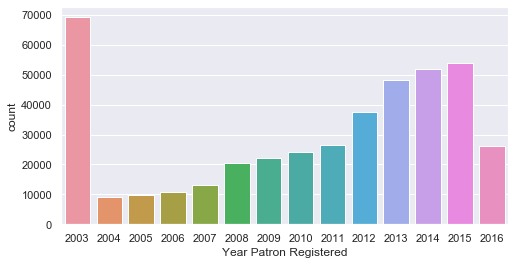

In [32]:
sns.countplot(x='Year Patron Registered',data=df)
sns.set(rc={'figure.figsize':(11.7,8.27)})

### Notice Preference Definition/Provided Email Address
Not much surprised here. Most patrons prefer to receive notifications (such as when their holds are ready for pickup, when a book is overdue) through email. 
Those who do not provide email opted to receive notification via phone (second preferred option) and mail (print). 

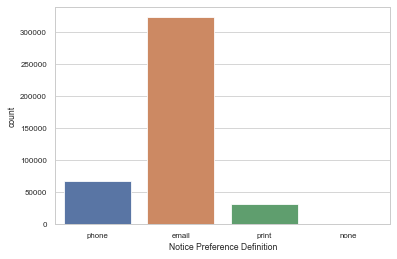

In [20]:

sns.countplot(x='Notice Preference Definition',data=df)



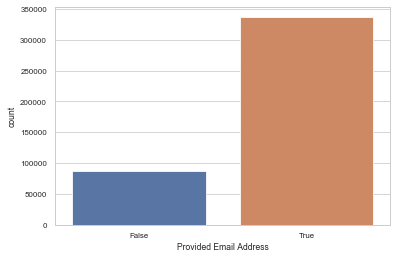

In [19]:
sns.countplot(x='Provided Email Address',data=df)

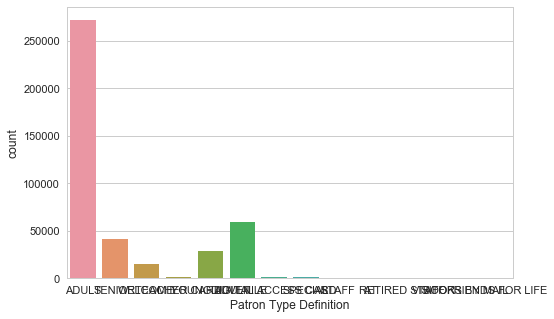

In [22]:
sns.countplot(x='Patron Type Definition',data=df)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [21]:

df.groupby(['Patron Type Definition'])['avg_cko'].agg(['count','median','min','max'])

,count,median,min,max
Patron Type Definition,,,,
ADULT,272251,5.166667,0.0,2771.000000
AT,551,4.000000,0.0,686.500000
BOOKS BY MAIL,95,20.000000,0.0,524.461538
DIGITAL ACCESS CARD,1744,0.000000,0.0,491.000000
FRIENDS FOR LIFE,40,34.192308,0.0,838.600000
JUVENILE,59208,16.000000,0.0,1413.000000
RETIRED STAFF,157,77.692308,0.0,628.153846
SENIOR,41619,8.400000,0.0,2567.100000
SPECIAL,977,15.923077,0.0,1564.000000


In [31]:
# Reduce the number of categories
df['Patron Type Definition']=df['Patron Type Definition'].replace("AT USER ADULT","OTHER")
df['Patron Type Definition']=df['Patron Type Definition'].replace("AT USER JUVENILE","OTHER")
df['Patron Type Definition']=df['Patron Type Definition'].replace("AT USER SENIOR","OTHER")
df['Patron Type Definition']=df['Patron Type Definition'].replace("AT USER WELCOME","OTHER")
df['Patron Type Definition']=df['Patron Type Definition'].replace("AT USER TEEN","OTHER")
df['Patron Type Definition']=df['Patron Type Definition'].replace("AT USER TEEN","OTHER")
df['Patron Type Definition']=df['Patron Type Definition'].replace("FRIENDS FOR LIFE","OTHER")
df['Patron Type Definition']=df['Patron Type Definition'].replace("DIGITAL ACCESS CARD","OTHER")
df['Patron Type Definition']=df['Patron Type Definition'].replace("RETIRED STAFF","OTHER")
df['Patron Type Definition']=df['Patron Type Definition'].replace("VISITOR","OTHER")
df['Patron Type Definition']=df['Patron Type Definition'].replace("BOOK BY MAIL","OTHER")
df['Patron Type Definition']=df['Patron Type Definition'].replace("SPECIAL","OTHER")


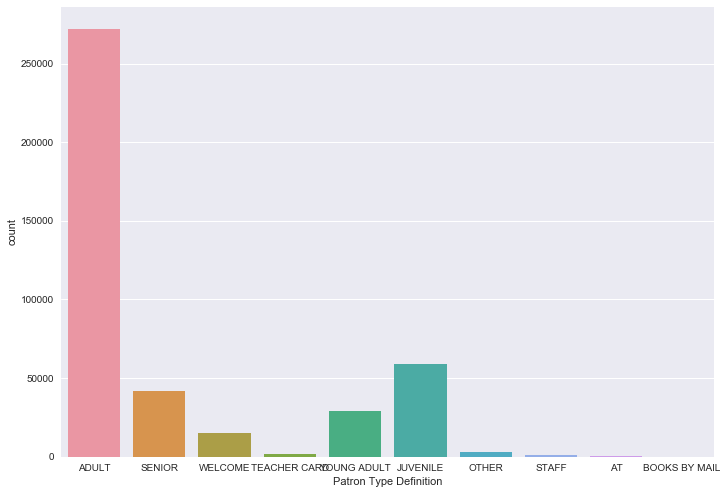

In [30]:
sns.countplot(x='Patron Type Definition',data=df)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [32]:

df.groupby(['Patron Type Definition'])['avg_cko'].agg(['count','median','min','max'])

,count,median,min,max
Patron Type Definition,,,,
ADULT,272251,5.166667,0.0,2771.000000
AT,551,4.000000,0.0,686.500000
BOOKS BY MAIL,95,20.000000,0.0,524.461538
JUVENILE,59208,16.000000,0.0,1413.000000
OTHER,3333,0.000000,0.0,1564.000000
SENIOR,41619,8.400000,0.0,2567.100000
STAFF,862,85.250000,0.0,1299.000000
TEACHER CARD,1782,20.250000,0.0,947.000000
WELCOME,14931,0.250000,0.0,325.153846


### Home Library Code/Home Library Definition 
Most of the traffic seems to be from Main Library, which is likely to be the biggest branch, with the most programming activities there. It is also more likely to be in downtown, making it the centre of actions. These factors are all likely boost circulaton activites. 

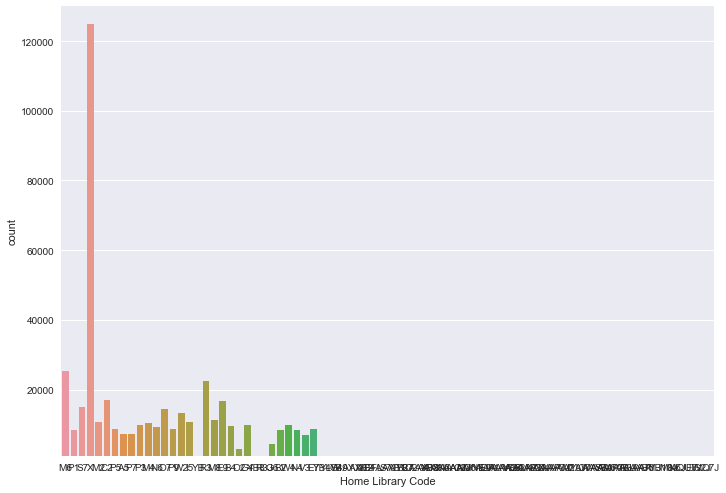

In [35]:

sns.countplot(x='Home Library Code',data=df)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.ylim(1000,130000);

In [34]:
# Try to reduce the number of Home Library by combining Branch Mobile 

df['Home Library Definition']=df['Home Library Definition'].replace("Branch Bookmobile (Excelsior)","Bookmobile")
df['Home Library Definition']=df['Home Library Definition'].replace("Branch Bookmobile (Marina)","Bookmobile")
df['Home Library Definition']=df['Home Library Definition'].replace("Branch Bookmobile (Sunset)","Bookmobile")
df['Home Library Definition']=df['Home Library Definition'].replace("Branch Bookmobile (West Portal)","Bookmobile")
df['Home Library Definition']=df['Home Library Definition'].replace("Children's Bookmobile","Bookmobile")


df.groupby(['Home Library Definition'])['avg_cko'].agg(['count','median','min','max'])

,count,median,min,max
Home Library Definition,,,,
Anza,7183,12.400000,0.0,986.692308
Bayview/Linda Brooks-Burton,8417,2.333333,0.0,1321.153846
Bernal Heights,9630,7.895833,0.0,843.714286
Bookmobile,968,6.519231,0.0,670.000000
Chinatown,17140,17.094017,0.0,1245.333333
Eureka Valley/Harvey Milk Memorial,8708,8.076923,0.0,1801.900000
Excelsior,16706,6.160256,0.0,1352.200000
Glen Park,9811,8.076923,0.0,986.307692
Golden Gate Valley,4381,6.000000,0.0,976.000000


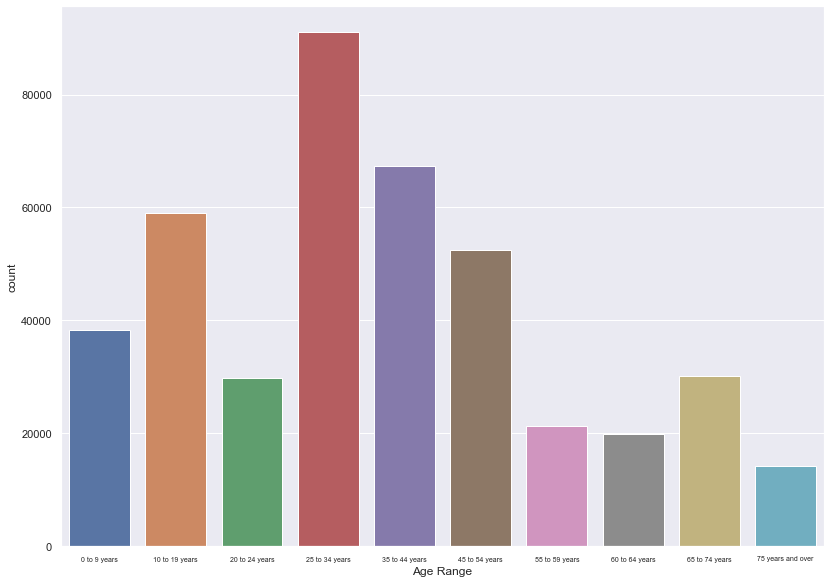

In [110]:

ax=sns.countplot(x='Age Range',order=('0 to 9 years','10 to 19 years','20 to 24 years','25 to 34 years','35 to 44 years','45 to 54 years', '55 to 59 years','60 to 64 years','65 to 74 years','75 years and over'),data=df)
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
plt.tight_layout()
plt.show()

### Age range 
At the first glance, it looks like the data is not normally distributed. However, note that the intervals are not the same: the width varies from 5 years to 10 years. Because of this, this is not a histrogram that could be used to determine whether there is any skewness in the data. 

If we redistribute "25 to 34 years","35 to 44 year", "45 to 54 years" so that each of these category would have an interval of ten years, it looks like the data would peak in the newly category of "30 to 39 years". This presumption is based on the likelihood that both "25 to 34 years" and "35 to 44 years" could be equally split into two parts and redistributed. Based on our literature review, we know that the median age of San Francisco is 38.9 year. This seems to be aligned with our findings with the library data

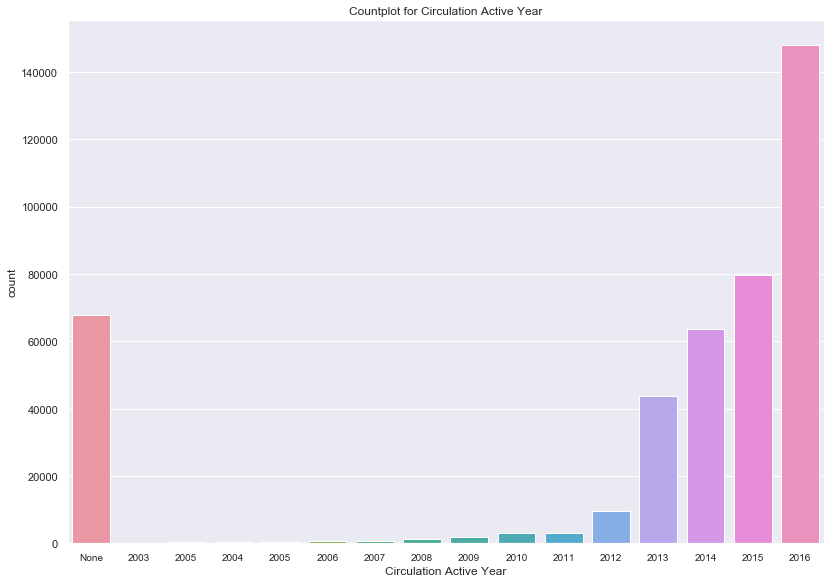

In [111]:
ax=sns.countplot(x="Circulation Active Year",hue_order='Supervisor District',order=('None','2003','2005','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016'),data=d
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
ax.set_title('Countplot for Circulation Active Year') 
plt.tight_layout()
plt.show()

### Circulation Last Year
This is interesting to see that most of the users have used the library in the past one year ("2016") or perhaps ("2015"). This indicates that SFPL has a lot of regular users.  

### Supervisor District

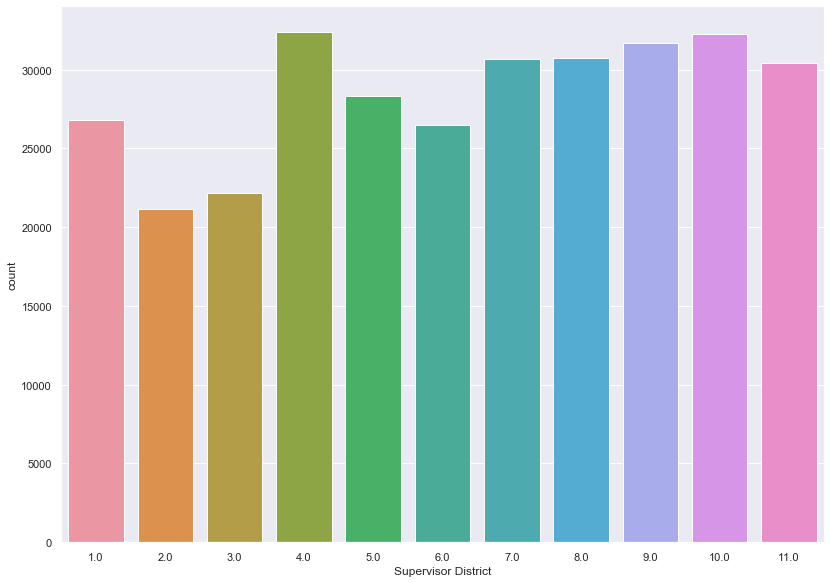

In [112]:
sns.countplot(x='Supervisor District',data=df)
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
plt.tight_layout()
plt.show()

With the exception of District two and District three, the data seems to be uniformly distributed. Further analysis will be done in a later section when combining with average checkouts (ckos) and also with the use of GeoPandas. 

## Numercial Variables

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


C:\Users\jochoi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


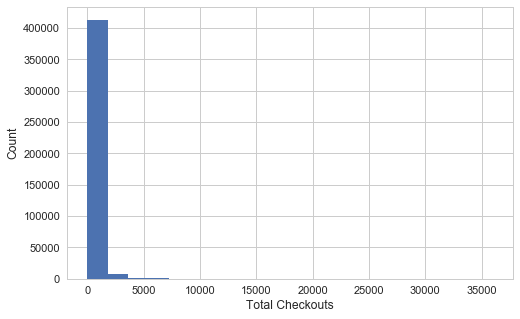

In [12]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

sns.distplot(df['total_cko'], norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}).set(xlabel='Total Checkouts', ylabel='Count');


C:\Users\jochoi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


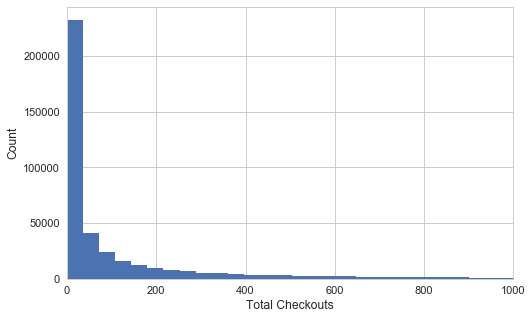

In [13]:

sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

sns.distplot(df['total_cko'], norm_hist=False, kde=False, bins=1000, hist_kws={"alpha": 1}).set(xlabel='Total Checkouts', ylabel='Count')
plt.xlim(0,1000);

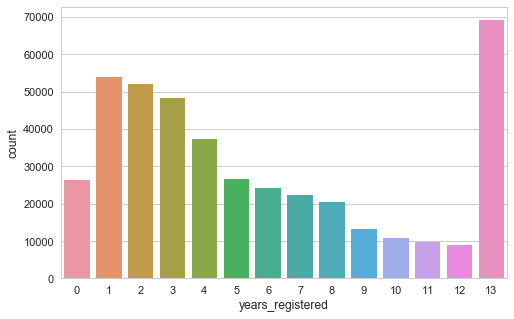

In [14]:

sns.countplot(x='years_registered',data=df)
sns.set(rc={'figure.figsize':(11.7,8.27)})

C:\Users\jochoi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


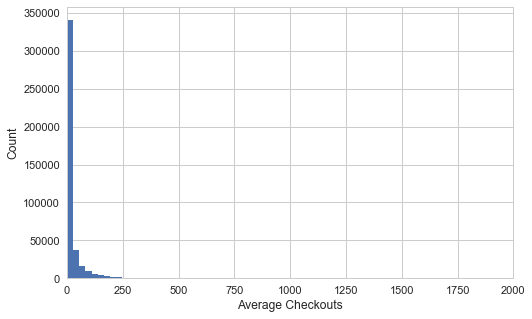

In [15]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

sns.distplot(df['avg_cko'], norm_hist=False, kde=False, bins=100, hist_kws={"alpha": 1}).set(xlabel='Average Checkouts', ylabel='Count')
plt.xlim(0,2000);

In [119]:
df.describe()

,Patron Type Code,Total Checkouts,Total Renewals,Year Patron Registered,Supervisor District,years_registered,avg_cko
count,423448.000000,423448.000000,423448.000000,423448.000000,313138.000000,423448.000000,423448.000000
mean,1.036765,161.982097,59.657327,2010.348917,6.288240,5.651083,21.878830
std,4.188198,453.703678,225.009917,4.357374,3.123634,4.357374,51.972197
min,0.000000,0.000000,0.000000,2003.000000,1.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,2007.000000,4.000000,2.000000,0.714286
50%,0.000000,19.000000,2.000000,2012.000000,6.000000,4.000000,4.444444
75%,1.000000,113.000000,27.000000,2014.000000,9.000000,9.000000,19.000000
max,104.000000,35907.000000,8965.000000,2016.000000,11.000000,13.000000,2762.076923


In [120]:
outliers=df[df['Total Checkouts']>10000]
print(outliers)

        Patron Type Code Patron Type Definition  Total Checkouts  \
895                    9                SPECIAL            18064   
2007                   0                  ADULT            10521   
3543                   0                  ADULT            12740   
20083                  3                 SENIOR            16060   
31334                  0                  ADULT            13784   
39620                  0                  ADULT            11086   
57244                  0                  ADULT            10906   
86671                  3                 SENIOR            11748   
117604                 0                  ADULT            11817   
120565                 3                 SENIOR            10108   
129328                 3                 SENIOR            12757   
138318                 0                  ADULT            10809   
145594                 3                 SENIOR            11871   
146589                 0                  ADULT 

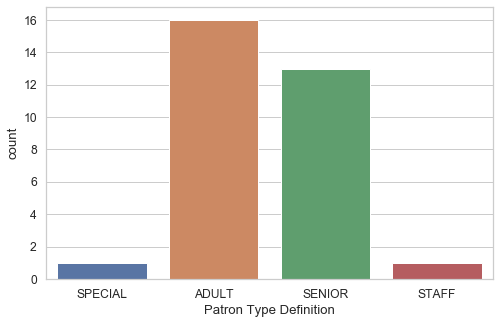

In [121]:
sns.countplot(x='Patron Type Definition',data=outliers)
plt.show()

# Dependent Variables

Create the label "Frequent" and "Infrequent" to use, so that we can test on using this dataset for prediction
"Frequent" is defined as user with 50 times average circulation activities (avg_cko). 
Below are various countplots to explore the relationship between this new variable ("user_category") and the existing variables. Nothing jump out when inspecting these plots. 

In [37]:
df['user_category']='Infrequent'
df['user_category'].loc[df['avg_cko']>50]='Frequent'

C:\Users\jochoi\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


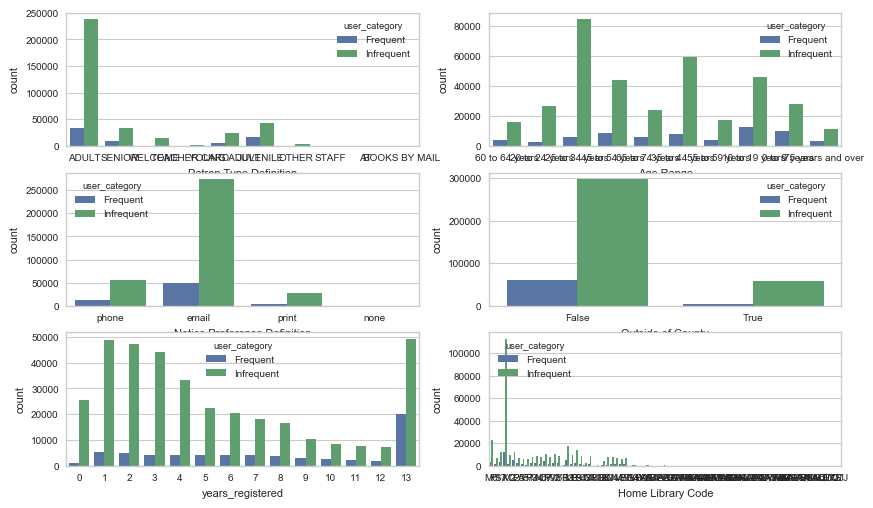

In [45]:
sns.set(style='whitegrid', rc={"grid.linewidth": 0.2})
sns.set_context("paper", font_scale=0.9)
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(10,6), dpi=100)
sns.countplot(x='Patron Type Definition',data=df,ax=axes[0][0],hue='user_category')
sns.countplot(x='Age Range',data=df,ax=axes[0][1],hue='user_category')
sns.countplot(x='Notice Preference Definition',data=df,ax=axes[1][0],hue='user_category')
sns.countplot(x='Outside of County',data=df,ax=axes[1][1],hue='user_category')
sns.countplot(x='years_registered',data=df,ax=axes[2][0],hue='user_category')
sns.countplot(x='Home Library Code',data=df,ax=axes[2][1],hue='user_category')


In [37]:
df.head()

,Patron Type Code,Patron Type Definition,Total Checkouts,Total Renewals,Age Range,Home Library Code,Home Library Definition,Circulation Active Month,Circulation Active Year,Notice Preference Code,Notice Preference Definition,Provided Email Address,Year Patron Registered,Outside of County,Supervisor District,years_registered,avg_cko,user_category
0,0,ADULT,1092,761,60 to 64 years,M6,Mission,July,2016,p,phone,False,2003,False,9.0,13,84.000000,Frequent
1,0,ADULT,0,0,20 to 24 years,P1,Park,None,None,z,email,True,2014,False,5.0,2,0.000000,Infrequent
2,0,ADULT,31,22,25 to 34 years,S7,Sunset,April,2016,z,email,True,2010,False,4.0,6,5.166667,Infrequent
3,0,ADULT,0,0,45 to 54 years,P1,Park,None,None,a,print,False,2016,True,NaN,0,0.000000,Infrequent
4,0,ADULT,0,0,25 to 34 years,X,Main Library,None,None,z,email,True,2015,False,3.0,1,0.000000,Infrequent


In [ ]:
#sorted_nb = df.groupby(['Supervisor District'])['avg_cko'].median().sort_values()
#sns.boxplot(x=df['Supervisor District'], y=df['avg_cko'], order=list(sorted_nb.index))
sns.boxplot(x=df['Supervisor District'], y=df['avg_cko'])

In [218]:
GB1=df.groupby(['Supervisor District'])['avg_cko'].agg(['count','median','min','max'])
#G1=df.groupby(['Supervisor District'])['avg_cko'].median()
GB1.head(20)

,count,median,min,max
Supervisor District,,,,
1.0,26787,8.000000,0.0,963.666667
2.0,21153,4.692308,0.0,1515.000000
3.0,22151,6.000000,0.0,1245.333333
4.0,32401,9.142857,0.0,1853.307692
5.0,28356,4.250000,0.0,1081.000000
6.0,26507,3.909091,0.0,2255.000000
7.0,30670,7.000000,0.0,1303.000000
8.0,30732,5.666667,0.0,1450.200000
9.0,31677,5.500000,0.0,2522.300000


In [219]:
gdf2 = gpd.read_file('data/Shapefile/Supervisor Districts as of April 2012/geo_export_2012.shp')

In [220]:
GB2=pd.merge(gdf2,GB1,left_on="supervisor",right_on="Supervisor District",how="left")
GB2.head()

,supname,supervisor,numbertext,supdist,geometry,count,median,min,max
0,Farrell,2.0,TWO,SUPERVISORIAL DISTRICT 2,"POLYGON ((-122.41922 37.80845, -122.41921 37.8...",21153,4.692308,0.0,1515.000000
1,Mar,1.0,ONE,SUPERVISORIAL DISTRICT 1,"POLYGON ((-122.49374 37.78761, -122.49367 37.7...",26787,8.000000,0.0,963.666667
2,Tang,4.0,FOUR,SUPERVISORIAL DISTRICT 4,"POLYGON ((-122.47485 37.76179, -122.47496 37.7...",32401,9.142857,0.0,1853.307692
3,Yee,7.0,SEVEN,SUPERVISORIAL DISTRICT 7,"POLYGON ((-122.44854 37.75904, -122.44847 37.7...",30670,7.000000,0.0,1303.000000
4,Wiener,8.0,EIGHT,SUPERVISORIAL DISTRICT 8,"POLYGON ((-122.42327 37.77206, -122.42325 37.7...",30732,5.666667,0.0,1450.200000


In [221]:
gdf = gpd.read_file('data/Shapefile/geo_export.shp')
print(gdf)

    supname  supervisor numbertext                    supdist  \
0   Farrell         2.0        TWO   SUPERVISORIAL DISTRICT 2   
1       Mar         1.0        ONE   SUPERVISORIAL DISTRICT 1   
2      Tang         4.0       FOUR   SUPERVISORIAL DISTRICT 4   
3       Yee         7.0      SEVEN   SUPERVISORIAL DISTRICT 7   
4    Wiener         8.0      EIGHT   SUPERVISORIAL DISTRICT 8   
5    Avalos        11.0     ELEVEN  SUPERVISORIAL DISTRICT 11   
6    Campos         9.0       NINE   SUPERVISORIAL DISTRICT 9   
7     Cohen        10.0        TEN  SUPERVISORIAL DISTRICT 10   
8       Kim         6.0        SIX   SUPERVISORIAL DISTRICT 6   
9      Chiu         3.0      THREE   SUPERVISORIAL DISTRICT 3   
10    Breed         5.0       FIVE   SUPERVISORIAL DISTRICT 5   

                                             geometry  
0   POLYGON ((-122.41922 37.80845, -122.41921 37.8...  
1   POLYGON ((-122.49374 37.78761, -122.49367 37.7...  
2   POLYGON ((-122.47485 37.76179, -122.47496 37.7.

In [30]:
# %matplotlib inline
#gdf.plot()

In [234]:
sfpl_loc=pd.read_csv('data/sfpl_loc.csv')
sfpl_loc.head()
sfpl_loc=gpd.GeoDataFrame(sfpl_loc, geometry=gpd.points_from_xy(sfpl_loc.Longitude, sfpl_loc.Latitude))

<Figure size 432x288 with 0 Axes>

,supname,supervisor,numbertext,supdist,geometry,count,median,min,max
0,Farrell,2.0,TWO,SUPERVISORIAL DISTRICT 2,"POLYGON ((-122.41922 37.80845, -122.41921 37.8...",21153,4.692308,0.0,1515.000000
1,Mar,1.0,ONE,SUPERVISORIAL DISTRICT 1,"POLYGON ((-122.49374 37.78761, -122.49367 37.7...",26787,8.000000,0.0,963.666667
2,Tang,4.0,FOUR,SUPERVISORIAL DISTRICT 4,"POLYGON ((-122.47485 37.76179, -122.47496 37.7...",32401,9.142857,0.0,1853.307692
3,Yee,7.0,SEVEN,SUPERVISORIAL DISTRICT 7,"POLYGON ((-122.44854 37.75904, -122.44847 37.7...",30670,7.000000,0.0,1303.000000
4,Wiener,8.0,EIGHT,SUPERVISORIAL DISTRICT 8,"POLYGON ((-122.42327 37.77206, -122.42325 37.7...",30732,5.666667,0.0,1450.200000


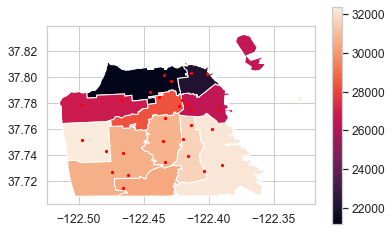

In [250]:
#import matplotlib.pyplot as plt
f, ax = plt.subplots(1)
gdf.plot(ax=ax)
gdf3=gpd.GeoDataFrame(GB2, geometry="geometry")

#gdf.plot(column='supdist', cmap=None, legend=True, figsize=(20, 20))
gdf3.plot(ax=ax,column='count', cmap=None, legend=True, figsize=(20, 20))
sfpl_loc.plot(ax=ax, marker='o', color='red', markersize=5);

gdf3.head()
#gdf.plot(column='supdist', cmap=None, legend=True, figsize=(20, 20))

In [ ]:
gdf3.plot(ax=ax,column='median', cmap=None, legend=True, figsize=(20, 20))
sfpl_loc.plot(ax=ax, marker='o', color='red', markersize=5);


In [ ]:
gdf3.plot(ax=ax,column='min', cmap=None, legend=True, figsize=(20, 20))
sfpl_loc.plot(ax=ax, marker='o', color='red', markersize=5);

In [ ]:
gdf3.plot(ax=ax,column='max', cmap=None, legend=True, figsize=(20, 20))
sfpl_loc.plot(ax=ax, marker='o', color='red', markersize=5);

In [240]:
GB1=df.groupby(['Supervisor District','Outside of County'])['avg_cko'].agg(['count','median','min','max'])

GB1.head(20)

count     median       min          max
Supervisor District Outside of County                                         
1.0                 False              26777   8.000000  0.000000   963.666667
                    True                  10   7.500000  0.666667   371.000000
2.0                 False              21135   4.692308  0.000000  1515.000000
                    True                  18   9.166667  0.000000   770.000000
3.0                 False              22113   6.000000  0.000000  1245.333333
                    True                  38   4.000000  0.000000   349.000000
4.0                 False              32382   9.125000  0.000000  1853.307692
                    True                  19  17.000000  0.000000   196.000000
5.0                 False              28319   4.250000  0.000000  1081.000000
                    True                  37   5.333333  0.000000   343.250000
6.0                 False              26434   3.923077  0.000000  2255.000000
                    True                  73   3.000000  0.000000   111.800000
7.0                 False              30616   7.076923  0.000000  1303.000000
                    True                  54   2.819444  0.000000   169.750000
8.0                 False              30709   5.666667  0.000000  1450.200000
                    True                  23   6.500000  0.000000   138.538462
9.0                 False              31650   5.500000  0.000000  2522.300000
                    True                  27   6.363636  0.000000   317.000000
10.0                False              32254   4.333333  0.000000  1000.666667
                    True                  14   7.583333  0.000000    48.166667